## Computación en paralelo 2 - Dask ETL (Extract, Transform, Load)

1. Chunks
2. Delay
3. Dask arrays
4. Dask DataFrames

In [1]:
# Establecer directorio
import os
os.chdir(r'C:\Users\JOSE MENDOZA\Dropbox\Projects\2023-2\QLab\PDs\bases')

In [2]:
! pip install graphviz

In [3]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'

### 1. Chunks

Estamos acostumbrados a cargar bases de datos de manera conjunta, es decir, una base contiene todas las observaciones. Pero cuando trabajamos con bases pesadas, puede ser conveniente *distribuir* la base en pedazos (chunks).

In [4]:
# Abrir base normalmente en pandas
import pandas as pd
base = 'cenagro2012_mod.dta'
cenagro = pd.read_stata(base) # Una sola base
cenagro.tail()

C:\Users\JOSE MENDOZA\anaconda3\lib\site-packages\pandas\io\stata.py:1514: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


,idua,sup_total,sexo,edad,lengua
2246697,250401005000083,34.0,Hombre,48,castellano
2246698,250401005000084,132.0,Hombre,35,castellano
2246699,250401005000085,20.5,Hombre,77,castellano
2246700,250401005000086,30.0,Mujer,30,castellano
2246701,250401005000087,30.0,Hombre,52,castellano


In [5]:
# Conteo del total de mujeres productoras
cenagro.groupby('sexo').count()

# Hay 691 921 mujeres productoras

,idua,sup_total,edad,lengua
sexo,,,,
Mujer,691921,691921,691921,691921
Hombre,1554781,1554781,1554781,1554781


In [6]:
# Abramos la base partida en chunks
for chunk in pd.read_stata(base , chunksize=500000):
    print('type: %s shape %s' % (type(chunk), chunk.shape))

C:\Users\JOSE MENDOZA\anaconda3\lib\site-packages\pandas\io\stata.py:1514: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


type: <class 'pandas.core.frame.DataFrame'> shape (500000, 5)
type: <class 'pandas.core.frame.DataFrame'> shape (500000, 5)
type: <class 'pandas.core.frame.DataFrame'> shape (500000, 5)
type: <class 'pandas.core.frame.DataFrame'> shape (500000, 5)
type: <class 'pandas.core.frame.DataFrame'> shape (246702, 5)


In [7]:
chunk.shape

(246702, 5)

In [8]:
chunk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246702 entries, 2000000 to 2246701
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   idua       246702 non-null  object  
 1   sup_total  246702 non-null  float32 
 2   sexo       246702 non-null  category
 3   edad       246702 non-null  int8    
 4   lengua     246702 non-null  category
dtypes: category(2), float32(1), int8(1), object(1)
memory usage: 5.4+ MB


In [9]:
m = (chunk.sexo == "Mujer")
chunk.loc[m].shape

(65426, 5)

Ok, pero esto corresponde **solo** al último chunk creado, que tiene 246701 observaciones de un total de 2246701

Si queremos aplicar el filtrado a toda la base, debemos incluirlo en el loop (for)

In [10]:
def filtro_mujeresprod(datos):
    mujeresprod = (datos.sexo == "Mujer")
    return datos.loc[mujeresprod]

In [11]:
chunks = []
for chunk in pd.read_stata(base , chunksize = 500000):
    chunks.append(filtro_mujeresprod(chunk))

C:\Users\JOSE MENDOZA\anaconda3\lib\site-packages\pandas\io\stata.py:1514: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [12]:
len(chunks)

5

In [13]:
lengths = [len(chunk) for chunk in chunks]
lengths[-10:]

[163562, 168203, 152207, 142523, 65426]

In [14]:
mujeres_prod = pd.concat(chunks)
mujeres_prod.shape

(691921, 5)

### 2. Delay

Estamos acostumbrados a que los comandos se ejecuten instantáneamente. Con Dask las cosas no son tan así...

In [15]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default

In [16]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 7.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59411,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.79 GiB
Comm: tcp://127.0.0.1:59448,Total threads: 2
Dashboard: http://127.0.0.1:59449/status,Memory: 1.95 GiB
Nanny: tcp://127.0.0.1:59416,


In [17]:
# Juguemos con algunas funciones simples
def f(x):
    return x + 2

def g(y):
    return y ** 3

def h(z):
    return z + 1

In [18]:
z = 1
y = h(z)
x = g(y)
w = f(x)
print(w)

10


In [19]:
from dask import delayed
y = delayed(h)(z)
x = delayed(g)(y)
w = delayed(f)(x)
print(w)

Delayed('f-3a404c53-910b-459e-a30f-8bbcb24ea379')


In [20]:
type(w)

dask.delayed.Delayed

In [21]:
w.compute()

10

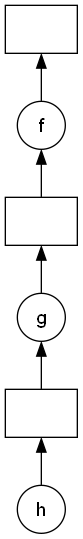

In [22]:
w.visualize()

In [45]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)

In [47]:
output = []
for x in data:
    a = delayed(inc)(x)
    b = delayed(double)(x)
    c = delayed(add)(a, b)
    output.append(c)

total = delayed(sum)(output)

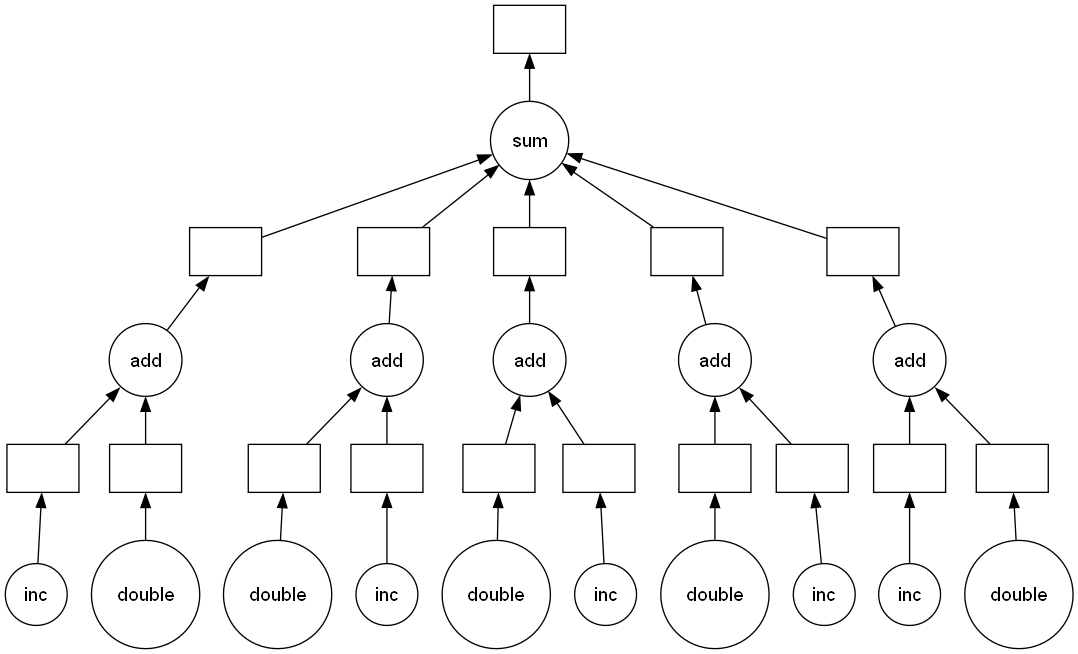

In [48]:
total.visualize()  # see image to the right

### 3. Dask arrays

Estamos acostumbrados a trabajar con numpy arrays... Dask tiene sus propios arrays (similares a los numpy)

In [23]:
# Generemos un numpy array 
import numpy as np
ar = np.random.rand(100000)
print(ar.shape, ar.dtype)

(100000,) float64


In [24]:
print(ar.sum())

50032.84006073371


In [25]:
# Ahora trabajemos con dask arrays
import dask.array as da
nchunks = 4
ar_dask = da.from_array(ar, chunks=len(ar) // nchunks)
ar_dask.chunks

((25000, 25000, 25000, 25000),)

In [26]:
# Hallar la sumatoria
result = ar_dask.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [27]:
print(result.compute())

50032.8400607337


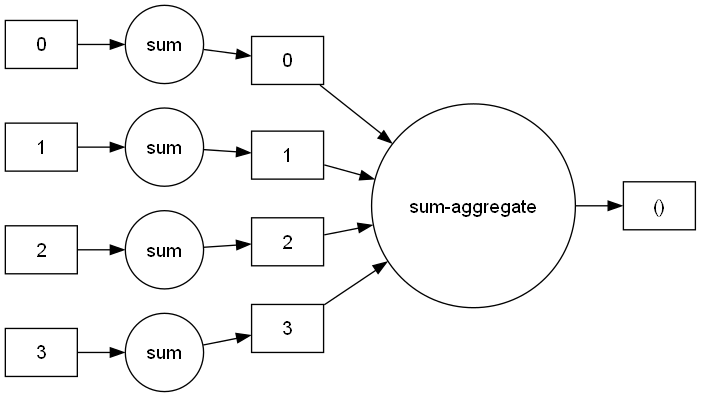

In [28]:
result.visualize(rankdir='LR')

In [29]:
# Podemos hallar también el valor máximo (como en la tarea)
maximo = ar_dask.max()

In [30]:
print(maximo.compute())

0.9999877303228988


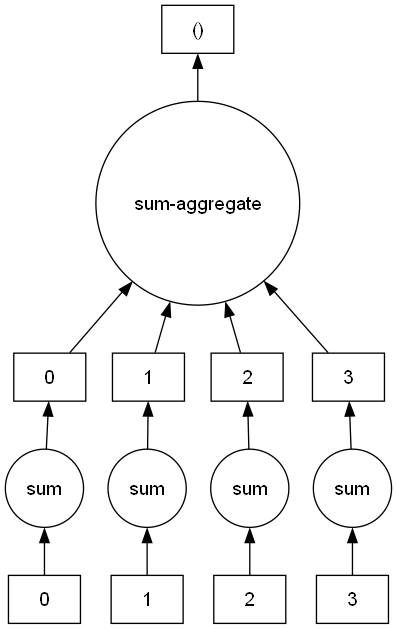

In [31]:
result.visualize()

También podemos hallar mínimos, promedios, desviación estándar, etc.

Los dask arrays también permiten utilizar shape , ndim , dtype , size , etc.

#### Veamos un ejercicio más con arrays usando datos temporales
La base que abriremos contiene la tasa de desempleo mensual (promedio de trimestres móviles) del 2002 al 2021. 

In [32]:
from numpy import genfromtxt
tdesemp = genfromtxt('desemp_mensualnn.csv', delimiter=',')
print(tdesemp.shape)

(240,)


In [33]:
# Reordenamos para poder obtener estadísticas mensuales
tdesemp_mensual = tdesemp.reshape((20,12))
tdesemp_mensual.shape

(20, 12)

In [34]:
# Promedio mensual
prom_mensual = tdesemp_mensual.mean(axis = 0)
prom_mensual

array([8.16246779, 8.82536562, 9.08929762, 8.69314494, 8.34970222,
       8.21933469, 7.94949372, 7.906205  , 7.97841581, 7.88119488,
       7.61332867, 7.43612998])

#### Ahora con dask arrays

In [35]:
tdesemp_dask = da.from_array(tdesemp , chunks = (12,))
tdesemp_dask_mensual = tdesemp_dask.reshape((20,12))
prom_mensual_dask = tdesemp_dask_mensual.mean(axis = 0)
prom_mensual_dask.compute()

array([8.16246779, 8.82536561, 9.08929762, 8.69314494, 8.34970222,
       8.21933469, 7.94949372, 7.90620501, 7.97841581, 7.88119488,
       7.61332867, 7.43612999])

In [36]:
tdesemp_dask.shape

(240,)

### 4. Dask dataframes
Estamos acostumbrados a trabajar con panda dataframes... Dask tiene sus propios dataframes (similares a los pandas)

In [37]:
import dask.dataframe as dd
daskdd = dd.read_csv('enaho500*.csv')
daskdd.head()
#daskdd.tail()

,ubigeo,dominio,ocu500,ocupinf,horas,pphoras48,idperso,periodo
0,10101,4,1,1.0,48.0,0,10051101,2013
1,10101,4,1,1.0,28.0,0,10051102,2013
2,10101,4,4,NaN,NaN,1,10051103,2013
3,10101,4,1,1.0,35.0,0,10231101,2013
4,10101,4,4,NaN,NaN,1,10231102,2013


In [38]:
daskdd.npartitions

7

#### Solo para ver el tiempo que nos ahorra dask

In [39]:
# Pandas
import pandas as pd
import time
t_start = time.time();
pandasdf = pd.read_csv('enaho500_2013.csv');
t_end = time.time();
print('read_csv: {} ms'.format((t_end-t_start)*1000))

read_csv: 115.1282787322998 ms


In [40]:
# Dask
import time
t_start = time.time();
daskdf = dd.read_csv('enaho500*.csv');
t_end = time.time();
print('read_csv: {} ms'.format((t_end-t_start)*1000))

read_csv: 26.02076530456543 ms


Cerrar con obteniendo estadísticas por año o algo así

In [41]:
daskdd.dtypes

ubigeo         int64
dominio        int64
ocu500         int64
ocupinf      float64
horas        float64
pphoras48      int64
idperso        int64
periodo        int64
dtype: object

In [42]:
daskdd_mod = daskdd.loc[(daskdd["ocupinf"].isin([1,2]))].replace({'ocupinf': 2},0)
daskdd_mod.groupby('periodo').count().compute()

,ubigeo,dominio,ocu500,ocupinf,horas,pphoras48,idperso
periodo,,,,,,,
2013,66814,66814,66814,66814,62384,66814,66814
2014,66144,66144,66144,66144,61726,66144,66144
2015,61498,61498,61498,61498,61498,61498,61498
2016,67827,67827,67827,67827,67827,67827,67827
2017,64915,64915,64915,64915,64915,64915,64915
2018,70036,70036,70036,70036,70036,70036,70036
2019,64954,64954,64954,64954,64954,64954,64954


In [43]:
daskdd_mod.groupby('periodo').mean().compute()

,ubigeo,dominio,ocu500,ocupinf,horas,pphoras48,idperso
periodo,,,,,,,
2013,127676.508262,4.999087,1.188209,0.802661,43.594191,0.397207,4.435546e+10
2014,128201.193366,5.022874,1.192036,0.795688,43.272835,0.385507,5.946107e+10
2015,129165.164818,5.002163,1.000000,0.782855,43.486715,0.340808,6.908586e+10
2016,129595.702154,4.831984,1.000000,0.771315,43.366956,0.339673,7.615868e+10
2017,130378.736902,4.883139,1.000000,0.769144,43.140075,0.333498,7.727682e+10
2018,129040.090068,4.935562,1.000000,0.773616,43.446420,0.343295,7.968395e+10
2019,130173.117452,4.868368,1.000000,0.773163,43.303438,0.336638,7.774422e+10
